In [3]:
import jax
import jax.numpy as jnp
from jax import grad
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

Coefficients: [[-1.38138283  3.46348217]]
Intercept: [0.36468616]
Predictions: [0 0 1 1 0 0 0 1 0 0]


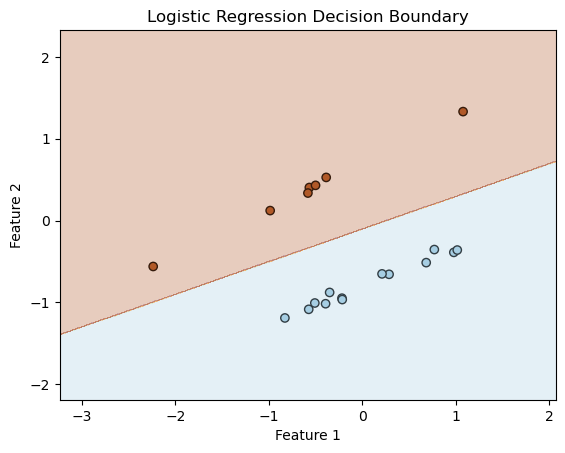

In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a binary classification dataset
X, y = make_classification(
    n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Display the coefficients and intercept
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)

# Make predictions on the test set
y_pred = logreg.predict(X_test)
print("Predictions:", y_pred[:10])

# Plot the decision boundary and data points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot the decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.title("Logistic Regression Decision Boundary")
plt.show()

In [7]:
def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))


def loss(X, y, params):
    w, b = params
    y_hat = sigmoid(X @ w + b)
    return -jnp.mean(y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat))


loss_jit = jax.jit(loss)
grad_loss_jit = jax.jit(grad(loss, argnums=2))

num_samples = X_train.shape[0]
minibatch_size = 1


def sgd(X, y, params, lr=0.01, num_epochs=10):
    history = []
    b_history = []
    w, b = params
    for epoch in range(num_epochs):
        b_history.append(b)
        idx_minibatch = np.random.choice(num_samples, minibatch_size)
        grads = grad_loss_jit(X_train[idx_minibatch], y_train[idx_minibatch], params)
        w -= lr * grads[0]
        b -= lr * grads[1]

        params = (w, b)
        history.append(loss_jit(X, y, params))
        print(f"Epoch {epoch + 1} Loss {history[-1]}, w {w}, b {b}")
    return w, b, history, b_history


params = (jnp.zeros(2), 0.0)
w, b, history, b_history = sgd(X_train, y_train, params, lr=0.1, num_epochs=10000)

Epoch 1 Loss 0.6856544017791748, w [-0.01633098  0.02651235], b -0.05000000074505806
Epoch 2 Loss 0.6489879488945007, w [0.05536129 0.10093645], b 0.0008554868400096893
Epoch 3 Loss 0.6301884055137634, w [0.07692856 0.1443571 ], b 0.04787237197160721
Epoch 4 Loss 0.6101906895637512, w [0.11420593 0.2008172 ], b 0.0027666687965393066
Epoch 5 Loss 0.5925483703613281, w [0.16551581 0.2561041 ], b -0.03672299161553383
Epoch 6 Loss 0.5731878876686096, w [0.22517377 0.31439435], b -0.004022292792797089
Epoch 7 Loss 0.5641123652458191, w [0.227976   0.35099617], b -0.04689202457666397
Epoch 8 Loss 0.5574250221252441, w [0.22912826 0.38175234], b -0.08925409615039825
Epoch 9 Loss 0.5516678690910339, w [0.16307244 0.38533834], b -0.031169254332780838
Epoch 10 Loss 0.5414009094238281, w [0.20384167 0.42926762], b -0.062546506524086
Epoch 11 Loss 0.5348032116889954, w [0.20169026 0.46092832], b -0.10296818614006042
Epoch 12 Loss 0.5228322148323059, w [0.22020695 0.49882874], b -0.0637340024113655

Text(0.5, 1.0, 'Logistic Regression Decision Boundary')

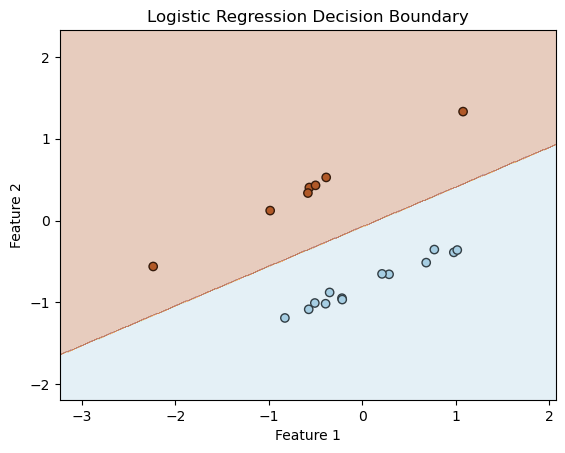

In [9]:
def makePredictions(X, w, b):
    predictions = sigmoid(jnp.dot(X, w) + b)
    return jnp.where(predictions >= 0.5, 1, 0)


# Plot the decision boundary and data points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot the decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

# Now plot the decision boundary using a trained model
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Use the trained model to make predictions on the mesh grid
Z = makePredictions(np.c_[xx.ravel(), yy.ravel()], w, b)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.title("Logistic Regression Decision Boundary")

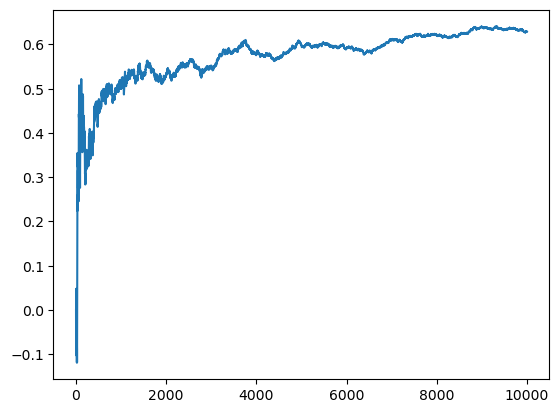

In [8]:
#Run the stochastic gradient descent and plot the parameter b as a function of the number of iterations taken
plt.plot(b_history)


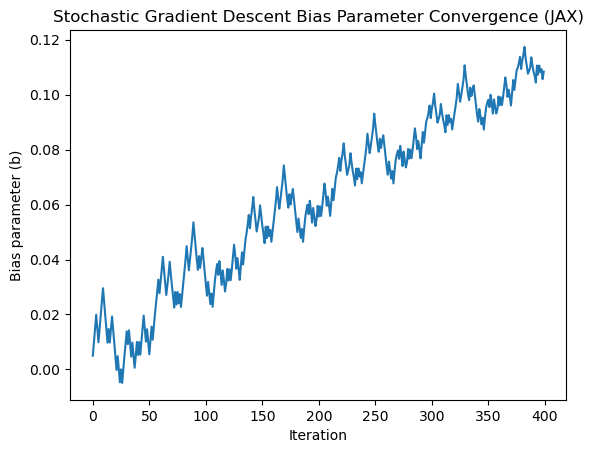

In [11]:
import jax.numpy as jnp
from jax import grad, jit


# Re-define the sigmoid function using JAX
def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))


# Logistic Regression prediction function
def predict(w, b, X):
    return sigmoid(jnp.dot(X, w) + b)


# Loss function for logistic regression (binary cross-entropy)
def loss(w, b, X, y):
    predictions = predict(w, b, X)
    return -jnp.mean(y * jnp.log(predictions) + (1 - y) * jnp.log(1 - predictions))


# Calculate gradients of the loss function using JAX
grad_loss = jit(grad(loss, argnums=(0, 1)))


# Stochastic Gradient Descent for Logistic Regression using JAX for gradient calculation
def stochastic_gradient_descent(X, y, learning_rate, epochs):
    m, n = X.shape
    w = jnp.zeros(n)
    b = 0.0
    b_history = []

    for epoch in range(epochs):
        for i in range(m):
            # Calculate gradients
            gradients = grad_loss(w, b, X[i : i + 1], y[i : i + 1])
            gradient_w = gradients[0]
            gradient_b = gradients[1]

            # Update parameters
            w -= learning_rate * gradient_w
            b -= learning_rate * gradient_b

            b_history.append(b)  # Store b for plotting

    return w, b, b_history


# Parameters (using the same synthetic data and parameters as before)
learning_rate = 0.01
epochs = 5  # 5 full passes over the dataset

# Run SGD
w, b, b_history = stochastic_gradient_descent(X_train, y_train, learning_rate, epochs)

# Plot the parameter b over iterations
plt.plot(b_history)
plt.xlabel("Iteration")
plt.ylabel("Bias parameter (b)")
plt.title("Stochastic Gradient Descent Bias Parameter Convergence (JAX)")
plt.show()